In [2]:
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 42.4 MB/s eta 0:00:0000:0100:01
  Using cached pytz-2022.7.1-py2.py3-none-any.whl (499 kB)


In [4]:
import tensorflow as tf
import pandas as pd
import matplotlib
import sklearn 
import os
import numpy as np

In [5]:
df = pd.read_csv(os.path.join("Data/train.csv"))

In [6]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
df.iloc[6]["comment_text"]

'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK'

In [8]:
df[df.columns[2:]].iloc[6]

toxic            1
severe_toxic     1
obscene          1
threat           0
insult           1
identity_hate    0
Name: 6, dtype: int64

In [9]:
from tensorflow import keras

In [10]:
from keras.layers import TextVectorization

In [11]:
X = df["comment_text"]
y = df[df.columns[2:]].values

In [15]:
max_features = 150000

In [16]:
vectorizer = TextVectorization(max_tokens=max_features,
                               output_sequence_length=1800,
                               output_mode="int")

2023-01-21 13:52:25.844877: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
vectorizer.adapt(X.values)

In [22]:
# vectorizer.get_vocabulary()

In [24]:
vectorizer("Hello World, life is great.")[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([288, 263, 306,   9, 275])>

In [25]:
vectorized_text = vectorizer(X.values)

In [26]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [28]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [34]:
batch_X, batch_y = dataset.as_numpy_iterator().next()
batch_y.shape

(16, 6)

In [35]:
train = dataset.take(int(len(dataset)*0.7))
val = dataset.skip(int(len(dataset)*0.7)).take(int(len(dataset)*0.2))
test = dataset.skip(int(len(dataset)*0.9)).take(int(len(dataset)*0.1))

In [38]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [39]:
model = Sequential()
model.add(Embedding(max_features+1, 32))
model.add(Bidirectional(LSTM(32, activation="tanh"))) # Ex: "I don't hate you" --> reads in "bidirectional" order
model.add(Dense(128, activation="relu")) 
model.add(Dense(256, activation="relu")) 
model.add(Dense(128, activation="relu")) 
model.add(Dense(6, activation="relu")) 

In [43]:
model.compile(loss="BinaryCrossentropy", optimizer="Adam")

In [44]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          4800032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                      

In [68]:
history = model.fit(train, epochs=1, validation_data=val)

Epoch 1/10
  74/6981 [..............................] - ETA: 43:32 - loss: 0.2626

KeyboardInterrupt: 

In [69]:
from matplotlib import pyplot as plt

In [70]:
history.history

{'loss': [0.2572811245918274], 'val_loss': [0.2332804799079895]}

<Figure size 576x360 with 0 Axes>

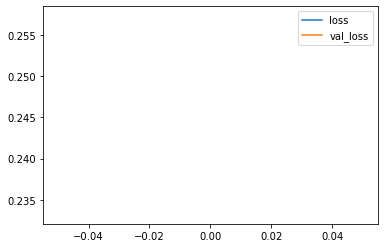

In [71]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [65]:
input_text = vectorizer("You freaking suck! I will kill you!")

In [66]:
res = model.predict(np.expand_dims(input_text, 0))

1/1 [==============================] - 0s 71ms/step


In [67]:
res

array([[1.3769543 , 0.        , 0.        , 0.        , 0.82018816,
        0.        ]], dtype=float32)

In [79]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [80]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 106ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [81]:
batch_y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [82]:
from keras.metrics import Precision, Recall, CategoricalAccuracy

In [83]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [85]:
for batch in test.as_numpy_iterator():
    X_true, y_true = batch
    y_hat = model.predict(X_true)
    
    y_true = y_true.flatten()
    y_hat = y_hat.flatten()
    
    pre.update_state(y_true, y_hat)
    re.update_state(y_true, y_hat)
    acc.update_state(y_true, y_hat)

1/1 [==============================] - 0s 90ms/step


In [87]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.9653179049491882, Recall: 0.047002531588077545, Accuracy: 0.31594783067703247


In [88]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 6.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.2/489.2 kB 6.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 5.1 MB/s eta 0:00:00a 0:00:01
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.8/812.8 kB 6.4 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Using cached jso

In [89]:
!pip install jinja2

In [90]:
import gradio as gr

In [91]:
model.save("toxicity.h5")

In [92]:
input_str = vectorizer("I hate you so much!")

In [93]:
res = model.predict(np.expand_dims(input_str, 0))

1/1 [==============================] - 0s 92ms/step


In [94]:
res

array([[0.2342329 , 0.        , 0.        , 0.        , 0.18165062,
        0.        ]], dtype=float32)

In [96]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment) 
    
    text = ""
    for idx, col in enumerate(df.columns[2:]):
        text += "{}: {}\n".format(col, results[0][idx]>0.5)
       
    return text

In [97]:
interface = gr.Interface(fn=score_comment,
                         inputs=gr.inputs.Textbox(lines=2, placeholder="Comment to Score"),
                         outputs="text")

/Users/liranpod/miniconda3/envs/experimental/lib/python3.10/site-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/Users/liranpod/miniconda3/envs/experimental/lib/python3.10/site-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/Users/liranpod/miniconda3/envs/experimental/lib/python3.10/site-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)


In [104]:
# interface.launch(share=False)

In [105]:
interface.close()

Closing server running on port: 7860
